# Quality assessment: Gravimetric mass balance data for the Antarctic and Greenland ice sheets from 2003 to 2020 derived from satellite observations

### Use Case: Using Greenland and Antarctic ice sheet mass change data as indicators for global climatic and water cycle changes in the context of the current global warming.

### User Question: Is the dataset sufficiently consistent in terms of spatio-temporal completeness and resolution to derive multi-year trends in ice sheet mass changes and their corresponding contribution to global sea level rise?

This script summarizes the scientific quality assessment provided for the C3S_520 service regarding Gravimetric Mass Balance (GMB) data for the Greenland (GrIS) and Antarctic Ice Sheet (AIS) as they are available on the Climate Data Store (CDS).

## General description

The mass balance of an ice sheet is the difference between mass gained (from snow accumulation) and mass lost (by melting/runoff or ice discharge into the ocean), which is the same as the net mass change of the ice sheet. Remote sensing techniques, such as the use of satellites, are an important feature to derive and study the mass changes of the ice sheets. Remote sensing devices, such as used by the GRACE and GRACE-FO (Gravity Recovery and Climate Experiment / Follow-On) missions, are able to inspect directly and repeatedly large areas of ice. More particularly, the GRACE(-FO) mission is able to detect changes within the Earth’s gravitational field, and further processing of these data transforms this raw information into mass balance and grounded mass change data. Remote sensing techniques that use satellite data are therefore considered the only feasible manner to derive accurate mass change data of the remote ice sheets on a regular basis. These techniques, however, also have their limitations of which the user should take note before using the product. 

One of the drawbacks of gravimetry-derived mass changes is the coarse spatial resolution at which data are acquired (i.e. the time series at the CDS is derived from data with a spatial resolution of 50x50 km). Although this number is at its minimum GCOS requirement (World Meteorological Organization, 2022), the large spatial extent of data acquisition makes mass change estimates sensitive to leakage errors. Another large source of uncertainty arises due to the fact that mass redistributions in the Earth’s interior because of glacial isostatic adjustment (i.e. as a response to past and present ice sheet mass changes) likewise impact the gravity solution. A last limitation of the CDS data is the fact that no gridded data are provided, which makes the user unable to investigate gridded patterns of mass changes. Caution is furthermore warranted for proper interpretation of (gravimetric) mass balance data. Mass change data measured by GRACE(-FO) comprises the total mass balance of grounded ice or land ice, i.e. the surface mass balance (accumulation minus runoff) and basal mass balance, together with solid ice discharge (i.e. the ice flux through the grounding line). Once ice crosses the grounding line, it becomes afloat and its mass changes (i.e. ice calving at the ice shelf front or basal melting of floating ice due to warm ocean water beneath) are no longer detected by GRACE(-FO). 

Mapping the ice sheet mass changes and its temporal variability provides key information for investigating the  response of glaciers and ice sheets to changing boundary conditions such as climate change (e.g. Forsberg et al., 2017; Groh et al., 2019). High-quality products are therefore desired to accurately assess and understand the current general state, as well as the temporal evolution (i.e. climate change impact) of the ice sheets. Moreover, data maturity and high quality GMB data are evidently important when serving as input into an ice sheet modelling framework, for example to derive global sea level change contributions (e.g. Forsberg et al., 2017; WCRP Global Sea Level Budget Group, 2018; Sasgen et al., 2019; Groh et al., 2019; Fox-Kemper et al., 2021). 

## Setup and retrieval

#### Let's first load the required packages

Here, we will load all packages that are needed to run the code.

In [1]:
import netCDF4 as nc
import cdsapi
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import glob
import zipfile
import pyproj
import math
import warnings
from datetime import datetime
from dateutil import relativedelta
from astropy.time import Time
import pandas as pd
import seaborn as sns
from scipy.stats import linregress
import pwlf
import pymannkendall as mk

#### Set the data request

We set up the data request to download the data from the CDS.

In [4]:
c = cdsapi.Client()

c.retrieve(
    'satellite-ice-sheet-mass-balance',
    {
        'variable': 'all',
        'format': 'zip',
    },
    'download.zip')

2023-06-05 15:01:22,284 INFO Welcome to the CDS
2023-06-05 15:01:22,285 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/satellite-ice-sheet-mass-balance
2023-06-05 15:01:22,592 INFO Request is queued
2023-06-05 15:01:23,645 INFO Request is running
2023-06-05 15:01:25,203 INFO Request is completed
2023-06-05 15:01:25,204 INFO Downloading https://download-0008-clone.copernicus-climate.eu/cache-compute-0008/cache/data9/dataset-satellite-ice-sheet-mass-balance-2f80a0e2-388d-4825-8a09-d9fd927b7c76.zip to download.zip (13.7M)
2023-06-05 15:01:29,250 INFO Download rate 3.4M/s                               


Result(content_length=14369565,content_type=application/zip,location=https://download-0008-clone.copernicus-climate.eu/cache-compute-0008/cache/data9/dataset-satellite-ice-sheet-mass-balance-2f80a0e2-388d-4825-8a09-d9fd927b7c76.zip)

#### Unpack the downloaded data

Now that the data are downloaded, we can extract them out of the NetCDF file.

In [14]:
files = glob.glob('/Users/yoniverhaegen/download.zip')
files
for file in files:
    print('Unzipping:',file)

    with zipfile.ZipFile(file, 'r') as zip_ref:
        zip_ref.extractall('/Users/yoniverhaegen/')

Unzipping: /Users/yoniverhaegen/download.zip


In [2]:
# Dataset
dataset = nc.Dataset('/Users/yoniverhaegen/C3S_GMB_GRACE_vers3.nc')

#### Extract the mass balance data

Now we can extract the time series of mass balance values. These data have units in Gt and cover the land ice of the entire ice sheets.

In [3]:
# GrIS
gmb_gris = dataset['GrIS_total'][:]
gmb_gris.data;
# AIS
gmb_ais = dataset['AntIS_total'][:]
gmb_ais.data;

#### Extract the time variable

Here, we extract the time variable and convert it to decimal years for easy plotting of the time variable on the x-axis

In [4]:
# Extract time variable
time_gmb = dataset['time'][:]
time_gmb.data;
t_unit = dataset.variables['time'].units
n = len(time_gmb)
# Convert this to decimal years
time_convert = nc.num2date(time_gmb, t_unit)
date_year = np.zeros(n)
for i in range(0,n):
        time_convert_time=time_convert[i]
        d1_time = int(time_convert_time.strftime('%Y'))
        date_year[i]=d1_time
date_month = np.zeros(n)
for i in range(0,n):
        time_convert_time=time_convert[i]
        d1_time = int(time_convert_time.strftime('%m'))
        date_month[i]=d1_time
date_day = np.zeros(n)
for i in range(0,n):
        time_convert_time=time_convert[i]
        d1_time = int(time_convert_time.strftime('%d'))
        date_day[i]=d1_time
decimal_year = np.zeros(n)
for i in range(0,n):
        input_date =  datetime(int(date_year[i]), int(date_month[i]), int(date_day[i]))
        astropy_time_object = Time(input_date,format='datetime')
        decimal_year[i] = astropy_time_object.decimalyear

## Results and discussion

#### We can now finally plot the gravimetric mass balance data 

At last, the mass balance data at the ice sheet-wide scale are ready to be plotted. To do so, no additional processing of the data has been performed. From this, we can also determine the overall average mass change of the ice sheets. 

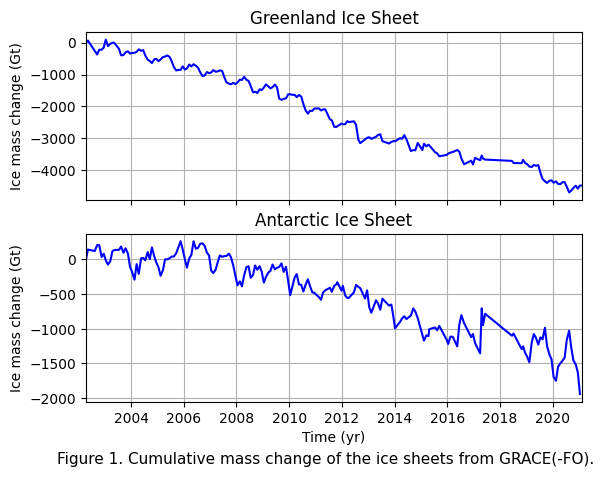

In [5]:
fig=plt.figure()
txt="Figure 1. Cumulative mass change of the ice sheets from GRACE(-FO)."
plt.figtext(0.5, -0.02,txt, wrap=True, horizontalalignment='center', fontsize=11)
# GrIS
plt.subplot(2,1,1)
plt.plot(decimal_year, gmb_gris.data-gmb_gris.data[0],color='blue')
plt.ylabel("Ice mass change (Gt)")
plt.title("Greenland Ice Sheet")
plt.xticks([2002,2004,2006,2008,2010,2012,2014,2016,2018,2020,2022])
plt.xticks(color='w')
plt.xlim(decimal_year[0], decimal_year[-1])
plt.grid()
# AIS
plt.subplot(2,1,2)
plt.plot(decimal_year, gmb_ais.data-gmb_ais.data[0],color='blue')
plt.ylabel("Ice mass change (Gt)")
plt.xlabel("Time (yr)")
plt.title("Antarctic Ice Sheet")
plt.xticks([2002,2004,2006,2008,2010,2012,2014,2016,2018,2020,2022])
plt.xlim(decimal_year[0], decimal_year[-1])
plt.grid()
plt.show()

The resulting time series is derived from data that exhibit a spatial coverage of the grounded ice of the entire GrIS at a coarse spatial resolution of 50 km, including the peripheral glaciers and ice caps. It therefore meets the minimum requirement proposed by the GCOS (Global Climate Observing System) (World Meteorological Organization, 2022). Ice shelves, on the other hand, are not incorporated. However, only the mass changes of the ice sheet resting on bedrock (grounded ice) are relevant for global sea level changes. Mass changes of the ice shelves do not affect the gravitational field, nor the global sea level in a direct way, as they are already afloat. Users should furthermore note that not only surface accumulation and melt can contribute to mass changes, as GRACE data are considered to be the sum of mass changes driven by changing rates of glacial discharge (ice dynamics) and mass changes driven by changing rates of melting and accumulation (basal and climatic conditions). Furthermore, it is worth to mention that indistinguishable effects of other factors can influence the Earth’s gravity field and may be intertwined in the obtained GRACE(-FO) mass change data, such as changes in the crust and mantle and tectonic activity.

The mass changes derived from GRACE(-FO) are expressed in Gt (Gigatonnes). Since the Gt is a unit of mass, one Gt of ice weighs exactly the same mass as a Gt of water. It can be translated into a volume, for example one Gt of water (density 1000 kg/m^3) is exactly 1 km^3, while one Gt of ice (density 917 kg/m^3) in volume becomes 1.091 km^3 of ice.

Let us calculate the average annual mass change for both ice sheets:

In [6]:
# First create the monthly GMB data
n = len(time_gmb)
delta_gmb_gris = np.zeros(n)
delta_gmb_ais = np.zeros(n)
for i in range(1, n):
    delta_gmb_gris[i]=gmb_gris.data[i]-gmb_gris.data[i-1]
    delta_gmb_ais[i]=gmb_ais.data[i]-gmb_ais.data[i-1]
# Rescale to yearly values
delta_gmb_gris = (np.roll(delta_gmb_gris, -1))*12
delta_gmb_ais = (np.roll(delta_gmb_ais, -1))*12
# Handle potential nan's
where_are_NaNs = np.isnan(delta_gmb_gris)
delta_gmb_gris[where_are_NaNs]=0
where_are_NaNs = np.isnan(delta_gmb_ais)
delta_gmb_ais[where_are_NaNs]=0
# Derive the mean values
print(f'The average annual mass change of the GrIS during the observed period is {np.nanmean(delta_gmb_gris):.1f}','Gt/yr.')
print(f'The average annual mass change of the AIS during the observed period is {np.nanmean(delta_gmb_ais):.1f}','Gt/yr.')

The average annual mass change of the GrIS during the observed period is -277.3 Gt/yr.
The average annual mass change of the AIS during the observed period is -120.1 Gt/yr.


From this analysis, it turns out that the average annual change in mass of the AIS, despite being larger in absolute surface area, is calculated to be lower than that of the GrIS, which has been losing mass at a higher rate. The negative values indicate that both ice sheets, in general, have been losing mass during the last two decades, i.e. more mass was removed than there was added to the ice sheet, resulting in net negative values.

#### Let us find out how many temporally missing data are present in the dataset

To do that, we need to find the amount of months present between the starting and ending date of the time series.

In [11]:
# Extract time variable
time_gmb = dataset['time'][:]
time_gmb.data;
t_unit = dataset.variables['time'].units
# Convert to date
time_convert_start = nc.num2date(time_gmb[0], t_unit)
time_convert_end = nc.num2date(time_gmb[-1], t_unit)
# get two dates
d1 = time_convert_start.strftime('%d/%m/%Y')
print('The start date of the time series is',d1)
d2 = time_convert_end.strftime('%d/%m/%Y')
print('The end date of the time series is',d2)
# convert string to date object
start_date = datetime.strptime(d1, "%d/%m/%Y")
end_date = datetime.strptime(d2, "%d/%m/%Y")
# Get the relativedelta between two dates
delta = relativedelta.relativedelta(end_date, start_date)
# get months difference
res_months = delta.months + (delta.years * 12)
print('The total amount of months that is expected between these two dates is', res_months,'months or',res_months/12,'years')
print('The actual amount of months that is present in the dataset is:',len(time_gmb))
print(f'This makes that the amount of missing data is {res_months-len(time_gmb)} months or {(100*(1-(len(time_gmb)/res_months))):.2f} %')

The start date of the time series is 16/04/2002
The end date of the time series is 13/02/2021
The total amount of months that is expected between these two dates is 225 months or 18.75 years
The actual amount of months that is present in the dataset is: 194
This makes that the amount of missing data is 31 months or 13.78 %


Temporal coverage is thus high, providing data at a monthly temporal resolution since 2002. There are however some missing intervals in the time series, especially after 2011 (e.g. a large section of data are missing between 2017 and 2019 in the transition period between GRACE and GRACE-FO).

#### Now, we can check for temporal variability of the mass changes

To do this, we calculate the monthly non-cumulative mass change time series for both ice sheets

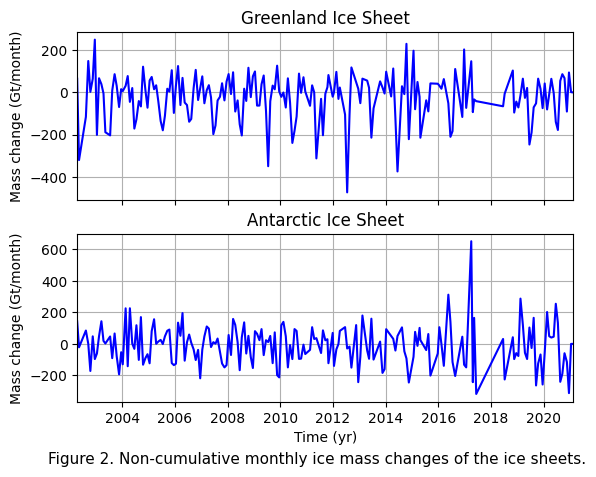

In [6]:
# First create the monthly GMB data
n = len(time_gmb)
delta_gmb_gris = np.zeros(n)
delta_gmb_ais = np.zeros(n)
for i in range(1, n):
    delta_gmb_gris[i]=gmb_gris.data[i]-gmb_gris.data[i-1]
    delta_gmb_ais[i]=gmb_ais.data[i]-gmb_ais.data[i-1]
delta_gmb_gris = (np.roll(delta_gmb_gris, -1))
delta_gmb_ais = (np.roll(delta_gmb_ais, -1))
# Handle potential nan's
where_are_NaNs = np.isnan(delta_gmb_gris)
delta_gmb_gris[where_are_NaNs]=0
where_are_NaNs = np.isnan(delta_gmb_ais)
delta_gmb_ais[where_are_NaNs]=0
# Plot these data
fig=plt.figure()
txt="Figure 2. Non-cumulative monthly ice mass changes of the ice sheets."
plt.figtext(0.5, -0.02,txt, wrap=True, horizontalalignment='center', fontsize=11)
# GrIS
plt.subplot(2,1,1)
plt.plot(decimal_year, delta_gmb_gris,color='blue')
plt.ylabel("Mass change (Gt/month)")
plt.title("Greenland Ice Sheet")
plt.xticks([2002,2004,2006,2008,2010,2012,2014,2016,2018,2020,2022])
plt.xlim(decimal_year[0], decimal_year[-1])
plt.xticks(color='w')
plt.grid()
# AIS
plt.subplot(2,1,2)
plt.plot(decimal_year, delta_gmb_ais,color='blue')
plt.ylabel("Mass change (Gt/month)")
plt.xlabel("Time (yr)")
plt.title("Antarctic Ice Sheet")
plt.xticks([2002,2004,2006,2008,2010,2012,2014,2016,2018,2020,2022])
plt.xlim(decimal_year[0], decimal_year[-1])
plt.grid()
plt.show()

We can now plot the statistics of mass changes per month as follows:

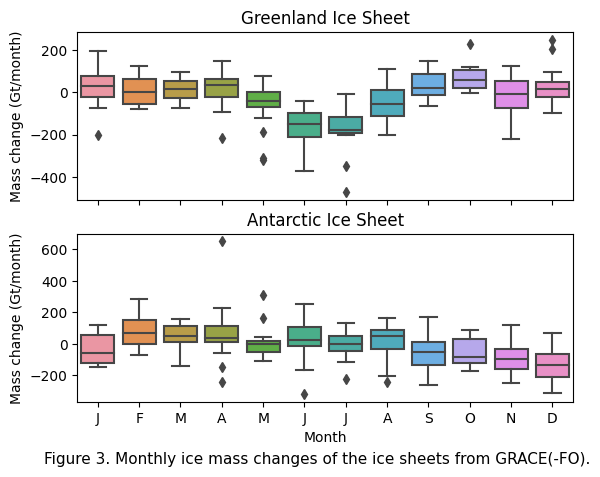

In [79]:
# Create a boxplot
fig=plt.figure()
txt="Figure 3. Monthly ice mass changes of the ice sheets from GRACE(-FO)."
plt.figtext(0.5, -0.02,txt, wrap=True, horizontalalignment='center', fontsize=11)
# GrIS
plt.subplot(2,1,1)
df=pd.DataFrame({'date_month': date_month, 'delta_gmb_gris':delta_gmb_gris});
ax=sns.boxplot(data=df, x='date_month', y='delta_gmb_gris');
ax.set_ylabel('Mass change (Gt/month)')
ax.set_xlabel('Mass change (Gt)',color='w')
plt.title("Greenland Ice Sheet")
ax.set_xticklabels(["J","F","M","A","M","J","J","A","S","O","N","D"],color='w');
# AIS
plt.subplot(2,1,2)
df=pd.DataFrame({'date_month': date_month, 'delta_gmb_ais':delta_gmb_ais});
ax=sns.boxplot(data=df, x='date_month', y='delta_gmb_ais');
plt.title("Antarctic Ice Sheet")
ax.set_xlabel('Month');
ax.set_ylabel('Mass change (Gt/month)');
ax.set_xticklabels(["J","F","M","A","M","J","J","A","S","O","N","D"]);
plt.show()

The monthly data clearly show intra-annual variation, with positive mass changes during the accumulation season and negative values during the melting season for the GrIS. Here, the most negative monthly mass change (lower than −400 Gt/month) was obtained by GRACE measurements in the record summer of 2012. 

#### At last, we can check whether there are ongoing trends with respect to the ice mass change data

First, we can check the linear trends and revise whether they are statistically significant with a Mann-Kendall test:

In [82]:
# Perform the analysis
res = linregress(decimal_year, gmb_gris.data-gmb_gris.data[0])
print(f'The linear trend of the mass changes of the GrIS during the observed period is {res[0]:.1f}','Gt/yr.')
res = linregress(decimal_year[:-1], gmb_ais.data[:-1]-gmb_ais.data[0])
print(f'The linear trend of the mass changes of the AIS during the observed period is {res[0]:.1f}','Gt/yr.')
# Check whether the trend is significant
sign_lvl = 0.05
result = mk.original_test(gmb_gris.data-gmb_gris.data[0], alpha=sign_lvl)
if result.p < sign_lvl:
    print(f'The obtained linear trend of the mass changes of the GrIS over time is significant at an alpha level of {sign_lvl}, i.e. a monotonic trend is present.')
else:
    print(f'The obtained linear trend of the mass changes of the GrIS over time is not significant at an alpha level of {sign_lvl}, i.e. a monotonic trend is not present')
    result = mk.original_test(gmb_ais.data-gmb_ais.data[0], alpha=sign_lvl)
if result.p < sign_lvl:
    print(f'The obtained linear trend of the mass changes of the AIS over time is significant at an alpha level of {sign_lvl}, i.e.  a monotonic trend is present.')
else:
    print(f'The obtained linear trend of the mass changes of the AIS over time is not significant at an alpha level of {sign_lvl}, i.e.  a monotonic trend is not present.')

The linear trend of the mass changes of the GrIS during the observed period is -255.6 Gt/yr.
The linear trend of the mass changes of the AIS during the observed period is -92.6 Gt/yr.
The obtained linear trend of the mass changes of the GrIS over time is significant at an alpha level of 0.05, i.e. a monotonic trend is present.
The obtained linear trend of the mass changes of the AIS over time is significant at an alpha level of 0.05, i.e.  a monotonic trend is present.


Let us also create a piecewise linear regression for the mass changes of both ice sheets:

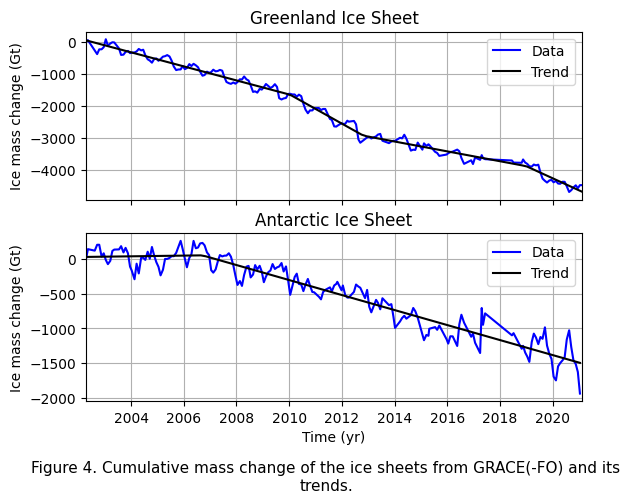

In [7]:
# Make a piecewise linear regression
x = decimal_year
y = gmb_gris.data-gmb_gris.data[0]
my_pwlf = pwlf.PiecewiseLinFit(x, y)
breaks_gris = my_pwlf.fit(4)
x_hat = np.linspace(x.min(), x.max(), 100)
y_hat = my_pwlf.predict(x_hat)
plt.figure()
txt="Figure 4. Cumulative mass change of the ice sheets from GRACE(-FO) and its trends."
plt.figtext(0.5, -0.07,txt, wrap=True, horizontalalignment='center', fontsize=11)
# GrIS
plt.subplot(2,1,1)
plt.plot(x, y,color='blue',label="Data")
plt.plot(x_hat, y_hat, 'k-',label="Trend")
plt.ylabel("Ice mass change (Gt)")
plt.title("Greenland Ice Sheet")
plt.xticks([2002,2004,2006,2008,2010,2012,2014,2016,2018,2020,2022])
plt.xlim(decimal_year[0], decimal_year[-1])
plt.xticks(color='w')
plt.legend(loc="upper right")
plt.grid()
x = decimal_year[:-1]
y = gmb_ais.data[:-1]-gmb_ais.data[0]
my_pwlf = pwlf.PiecewiseLinFit(x, y)
breaks_ais = my_pwlf.fit(2)
x_hat = np.linspace(x.min(), x.max(), 100)
y_hat = my_pwlf.predict(x_hat)
# AIS
plt.subplot(2,1,2)
plt.plot(x, y,color='blue',label="Data")
plt.plot(x_hat, y_hat, 'k-',label="Trend")
plt.ylabel("Ice mass change (Gt)")
plt.xlabel("Time (yr)")
plt.title("Antarctic Ice Sheet")
plt.legend(loc="upper right")
plt.xticks([2002,2004,2006,2008,2010,2012,2014,2016,2018,2020,2022])
plt.xlim(decimal_year[0], decimal_year[-1])
plt.grid()
plt.show()

For both ice sheets, a negative trend prevails, meaning that both ice sheets have been losing mass over time. For the GrIS, the analysis reveales accelerated mass losses until 2012-2013, followed by a slowdown until the years 2017-2018. Then, for the more recent period from 2019 onwards up until 2021, mass loss acceleration is reoccurring. For the AIS, mass changes were fairly stable fom 2002 until 2007, but slightly accelerating mass loss has been occuring ever since 2007-2008. Let us take the example of the AIS and quantify the linear (slope) and quadratic (acceleration) trends:

Equation linear trend: -92.587 * x + 185715.881, the slope is -92.587 Gt/yr.
Equation quadratic trend: -2.802 * x^2 + 11179.258 * x + -11152252.485, the acceleration is -5.603 Gt/yr^2.


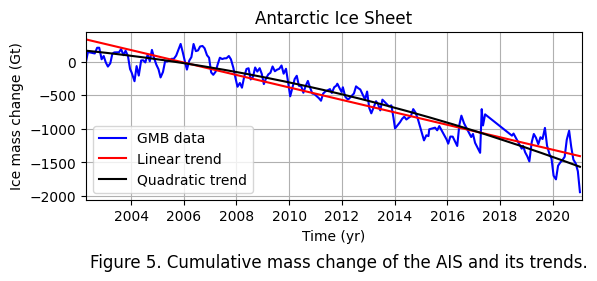

In [8]:
# Calculate the linear trend
res = linregress(decimal_year[:-1], gmb_ais.data[:-1]-gmb_ais.data[0])
print(f'Equation linear trend: {res[0]:.3f} * x + {res[1]:.3f}, the slope is {res[0]:.3f} Gt/yr.')
# Calculate the quadratic trend
model = np.poly1d(np.polyfit(decimal_year[:-1], gmb_ais.data[:-1]-gmb_ais.data[0], 2))
print(f'Equation quadratic trend: {model[2]:.3f} * x^2 + {model[1]:.3f} * x + {model[0]:.3f}, the acceleration is {2*model[2]:.3f} Gt/yr^2.')

# Plot data
fig=plt.figure()
txt="Figure 5. Cumulative mass change of the AIS and its trends."
plt.figtext(0.52, 0.39,txt, wrap=True, horizontalalignment='center', fontsize=12)
# AIS
plt.subplot(2,1,1)
plt.plot(decimal_year[:-1], gmb_ais.data[:-1]-gmb_ais.data[0],color='blue', label='GMB data')
plt.plot(decimal_year[:-1], res.intercept + res.slope*decimal_year[:-1], 'r', label='Linear trend')
plt.plot(decimal_year[:-1], model(decimal_year[:-1]), 'k', label='Quadratic trend')
plt.ylabel("Ice mass change (Gt)")
plt.title("Antarctic Ice Sheet")
plt.xlabel("Time (yr)")
plt.xticks([2002,2004,2006,2008,2010,2012,2014,2016,2018,2020,2022])
plt.xlim(decimal_year[0], decimal_year[-1])
plt.grid()
plt.legend(loc='lower left');

It turns out that the linear and quadratic trends of the change in mass of the AIS are both negative, which means that the rate of mass loss is slightly accelerating over time for the AIS. The negative values thus indicate that the ice sheet, in general, has been losing mass at an increasingly higher rate during the last two decades. 

## Conclusion

#### Key strengths and key weaknesses

<u>Key strengths</u>:

• The data can be easily displayed with open-source software and files are well structured.<br>
• The data have a long temporal extent and are found to be suitable to derive mean values, variability and trends (climate change signals).<br>
• The spatial resolution (time series is derived from data at 50 km), the temporal resolution
(monthly) and the timespan of data acquisition (all-year round) all satisfy the minimum GCOS requirements (World Meteorological Organization, 2022).<br>
• The time series includes data from all grounded ice across the whole ice sheet (i.e. includes peripheral glaciers and ice caps).<br>
• There is an abundant amount of guidance or help documents freely and publicly available. Contact information is also provided. <br>
• The data guidance documents are regularly updated, are publicly accessible and include
feedback. References to scientific peer-reviewed literature are also provided.<br>
• Data have been used in peer-reviewed research (e.g. Forsberg et al., 2017; WCRP Global Sea Level Budget Group, 2018; Sasgen et al., 2019; Groh et al., 2019).<br>

<u>Key weaknesses:</u>

• No gridded data are available for download, although they exist through other sources (e.g. the TU Dresden website).<br>
• Only grounded ice is considered in the dataset, mass changes of floating ice are not considered (while they are considered in, for example, the ice sheet surface elevation change dataset that is on the CDS).<br>
• Data gaps are present (e.g. during the transition period between GRACE and GRACE-FO in 2017-2019 CE). These are not filled up and not flagged, users need to identify them themselves. <br>
• For the GMB data, the help/guidance documents on the CDS are not as extensive as compared to the ice sheet ice velocity and surface elevation change datasets that are on the CDS. Rather, multiple references to other (scientific) documentation (e.g. from ESA-CCI) are provided. <br>
• The consistent inclusion of data generation and processing techniques (e.g. applied corrections) into the metadata would further improve the product’s quality. <br>
• Uncertainty is introduced due to leakage errors and corrections for e.g. glacial isostatic adjustment. Error values are large and are not at their minimum GCOS requirement of 10 km^3 yr^-1 (World Meteorological Organization, 2022). <br>
• Indistinguishable effects of other factors can influence the Earth’s gravity field and may be intertwined in the obtained GRACE(-FO) mass change data, such as changes in the crust and mantle and tectonic activity.<br>

#### Take-home messages

Mass change detection by GRACE(-FO) is a useful tool to grasp the impact of climate change on the ice sheets. The GMB dataset, however, also has its limitations of which the user should take note before using the product. For example, only grounded ice at very coarse spatial resolutions can be acquired by GRACE(-FO), leading to leakage errors and the fact that mass change of the floating ice shelves is neglected. However, in the sense of climate change impact, the direct contribution of floating ice shelves to global sea-level rise is quasi zero, as they are already afloat (cfr. Archimedes’ Principle). Another large problem with the data is, however, that no pixel-by-pixel products are included and the fact that there are a few temporal data gaps within the time series that are not flagged, nor filled up. Users should furthermore note that not only surface accumulation and melt can contribute to mass changes, as GRACE data are considered to be the sum of mass changes driven by changing rates of glacial discharge (ice dynamics) and mass changes driven by changing rates of melting and accumulation (basal and climatic conditions). 

By means of an uncertainty characterization, the error estimate should furthermore be consulted before proper usage of the GMB data. On the CDS, accuracy/precision is therefore represented by an average monthly error estimate in the time series files. Uncertainty is introduced mainly due to leakage errors and corrections for e.g. glacial isostatic adjustment. The corresponding error/uncertainty values are high (i.e. the error propagated throughout the time series is relatively large when compared to the actual cumulative mass change itself) and are not at their minimum GCOS requirement (World Meteorological Organization, 2022). In some cases for the GrIS, error estimates even exhibit values larger than 1000 Gt/month, while the threshiold of the GCOS is set to 10 km^3 yr^-1.

All in all, the time series of the ice-sheet wide GMB products are at this stage found to be suitable to derive mean, variability and trends (climate change signals), as (1) the amount of missing data is relatively limited (despite the gap between GRACE and GRACE-FO in 2017/2018), (2) the temporal resolution is consistent at a monthly basis, and (3) the number of consecutive years is sufficient to filter out inter- and intra-annual variability. The GMB products are thus found to be highly applicable to derive grounded mass changes over time and to, for example, assess the corresponding impact on global sea level changes. Because the GMB data are expressed as mass changes in Gt, they can be directly converted to global sea level change without additional corrections (if it is assumed that all mass changes contribute to sea level changes, which is realistic in the case of GRACE(-FO) data as ice mass changes of ice below buyoancy are not detected). Due to the high error and uncertainty values, however, the GMB product should be handled with care. 

## References

Forsberg R., Sørensen L., and Simonsen S. (2017). Greenland and Antarctica Ice Sheet Mass
Changes and Effects on Global Sea Level. In: Cazenave A., Champollion N., Paul F., Benveniste J.
(eds), Integrative Study of the Mean Sea Level and Its Components. Space Sciences Series of ISSI,
58, p. 91-106, Springer, Cham. https://doi.org/10.1007/978-3-319-56490-6_5.

Fox-Kemper, B., H.T. Hewitt, C. Xiao, G. Aðalgeirsdóttir, S.S. Drijfhout, T.L. Edwards, N.R. Golledge, M. Hemer, R.E. Kopp, G.  Krinner, A. Mix, D. Notz, S. Nowicki, I.S. Nurhati, L. Ruiz, J.-B. Sallée, A.B.A. Slangen, and Y. Yu (2021). Ocean, Cryosphere and Sea Level Change. In Climate Change 2021: The Physical Science Basis. Contribution of Working Group I to the Sixth Assessment Report of the Intergovernmental Panel on Climate Change [Masson-Delmotte, V., P. Zhai, A. Pirani, S.L.  Connors, C. Péan, S. Berger, N. Caud, Y. Chen, L. Goldfarb, M.I. Gomis, M. Huang, K. Leitzell, E. Lonnoy, J.B.R. Matthews, T.K. Maycock, T. Waterfield, O. Yelekçi, R. Yu, and B. Zhou (eds.)]. Cambridge University Press, Cambridge, United Kingdom and New York, NY, USA, pp. 1211–1362, https://doi.org/110.1017/9781009157896.011.

Groh, A., Horwath, M., Horvath, A., Meister, R., Sørensen, L.S., Barletta, V.R., Forsberg, R.,
Wouters, B., Ditmar, P., Ran, J., Klees, R., Su, X., Shang, K., Guo, J., Shum, C.K., Schrama, E., and
Shepherd, A. (2019). Evaluating GRACE Mass Change Time Series for the Antarctic and Greenland
Ice Sheet, Geosciences, 9(10). https://doi.org/10.3390/geosciences9100415.

Sasgen, I., Konrad, H., Helm, V., and Grosfeld, K. (2019). High-Resolution Mass Trends of the
Antarctic Ice Sheet through a Spectral Combination of Satellite Gravimetry and Radar Altimetry
Observations. Remote Sensing, 11(2):144. https://doi.org/10.3390/rs11020144.

WCRP Global Sea Level Budget Group (2018). Global sea-level budget 1993–present, Earth
System Science Data, 10, p. 1551–1590. https://doi.org/10.5194/essd-10-1551-2018.

World Meteorological Organization (2022). The 2022 GCOS ECVs Requirements (GCOS-245). World Meteorological Organization: Geneva, Switzerland.